In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from scipy.io import loadmat
from ipywidgets import interact
import xarray as xr
from sklearn.cluster import KMeans
from matplotlib.colors import ListedColormap, LogNorm
from mpl_toolkits.basemap import Basemap, shiftgrid

In [4]:
input_data = loadmat("/Users/dgagne/Google Drive/CEB/EXPORTS_data/Input/climAndTS_updated.mat")

In [18]:
lat = input_data["lat"]
lon = input_data["lon"]

* AlgEZ = flux of sinking algal cells and associated aggregates
* FecEZ = flux of fecal matter from zooplankton grazing
* NPP = Net Primary Production
* Chl = Clorophyll
* Zml = Mixed Layer Depth (m)
* Zeu = Eutrophic zone depth (m)
* PhytoC = Phytoplankton biomass?
* entrn = entrainment term
* Fm = the fraction of biomass in the microphytoplankton size class
* Gm = Grazing rates on large phytoplankton
* Gn = Grazing rate on small phytoplankton??
* dPmdt = time rate of change of biomass for microphytoplankton 
* dPndt = time rate of change of biomass for small phytoplankton
* s = n

In [5]:
data_files = sorted(glob("/Users/dgagne/Google Drive/CEB/EXPORTS_data/Output/*.npz"))
for data_file in data_files:
    print(data_file.split("/")[-1])

AlgEZ.npz
Chl.npz
FecEZ.npz
Fm.npz
Gm.npz
Gn.npz
NPP.npz
PhytoC.npz
Zeu.npz
Zml.npz
dPmdt.npz
dPndt.npz
entrn.npz


In [6]:
months = pd.DatetimeIndex(start="2001-01-01", end="2001-12-31", freq="1D").month
AlgEZ = np.load(data_files[0])
algez_data = AlgEZ["data"]
algez_data[algez_data == 1e20] = np.nan
AlgEZ_da = xr.DataArray(algez_data, dims=("doy", "lat", "lon"), coords={"doy": AlgEZ["doy"],
                                                                "lat": AlgEZ["lat"],
                                                                "lon": AlgEZ["lon"],
                                                                "month": ("doy", months)},
                        name="algez")

In [7]:
FecEZ = np.load(data_files[2])
fecez_data = FecEZ["data"]
fecez_data[fecez_data == 1e20] = np.nan
FecEZ_da = xr.DataArray(fecez_data, dims=("doy", "lat", "lon"), coords={"doy": AlgEZ["doy"],
                                                                "lat": AlgEZ["lat"],
                                                                "lon": AlgEZ["lon"], 
                                                                "month": ("doy", months)},
                        name="fecez")

In [ ]:
FecEZ_m = np.load(data_files[2])
fecez_data = FecEZ["data"]
fecez_data[fecez_data == 1e20] = np.nan
FecEZ_da = xr.DataArray(fecez_data, dims=("doy", "lat", "lon"), coords={"doy": AlgEZ["doy"],
                                                                "lat": AlgEZ["lat"],
                                                                "lon": AlgEZ["lon"], 
                                                                "month": ("doy", months)},
                        name="fecez")

In [17]:
def median(x):
    return np.median(x.values, axis=0)

combined_df = AlgEZ_da.groupby("month").median(axis=0).to_dataframe()
combined_df["fecez"] = FecEZ_da.groupby("month").median(axis=0).to_dataframe()
combined_df["cluster_id"] = -999

In [57]:
km = KMeans(n_clusters=5)
combined_df.loc[~np.isnan(combined_df["fecez"]), "cluster_id"] =  km.fit_predict(np.log10(combined_df[["algez", "fecez"]].dropna() + 1))
scaled_centers = 10 ** km.cluster_centers_ - 1


In [58]:
cluster_order = np.argsort(scaled_centers.sum(axis=1))
print(cluster_order)
new_cluster_ids = np.ones(combined_df.shape[0]) * -999
for cluster_id in range(5):
    new_cluster_ids[combined_df["cluster_id"].values == cluster_order[cluster_id]] = cluster_id
print(new_cluster_ids[new_cluster_ids > -1])
print(combined_df["cluster_id"].values[combined_df["cluster_id"].values > -1])
#combined_df["cluster_id"] = new_cluster_ids

[3 2 0 4 1]
[ 3.  3.  0. ...,  4.  0.  0.]
[ 4.  4.  3. ...,  1.  3.  3.]


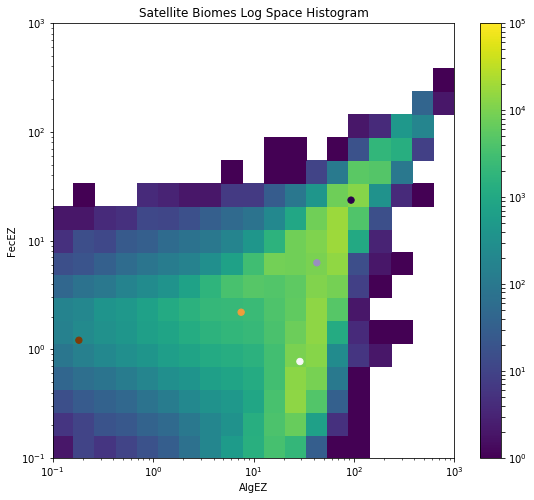

In [59]:
plt.figure(figsize=(9, 8))
combined_df_valid = combined_df.dropna()
xbins = np.logspace(-1, 3, 20)
ybins = np.logspace(-1, 3, 20)
counts, bb, bb2 = np.histogram2d(combined_df_valid["algez"], 
                 combined_df_valid["fecez"], bins=(xbins, ybins))
plt.pcolormesh(xbins, ybins, counts, norm=LogNorm(vmin=1, vmax=100000))
plt.colorbar()
plt.scatter(scaled_centers[cluster_order, 1], 
            scaled_centers[cluster_order, 0], 40, np.arange(0, 5), 
            cmap=plt.get_cmap("PuOr", 5))
plt.xlabel("AlgEZ")
plt.ylabel("FecEZ")
plt.gca().set_yscale("log")
plt.gca().set_xscale("log")
plt.xlim(0.1, 1000)
plt.ylim(0.1, 1000)
plt.title("Satellite Biomes Log Space Histogram")
plt.savefig("sat_biomes_hist.png", dpi=250, bbox_inches="tight")

In [60]:
bmap = Basemap(projection="robin", resolution="c", lon_0=0)
cluster_grid = new_cluster_ids.reshape(12, 180, 360)
#cluster_grid = combined_df["cluster_id"].values.reshape(12, 180, 360)
#new_cluster_grid, new_lons = shiftgrid(0, cluster_grid, FecEZ_da.lon)
lon_grid, lat_grid = np.meshgrid(FecEZ_da.lon, FecEZ_da.lat)

x, y = bmap(lon_grid, lat_grid)

/Users/dgagne/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/dgagne/anaconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


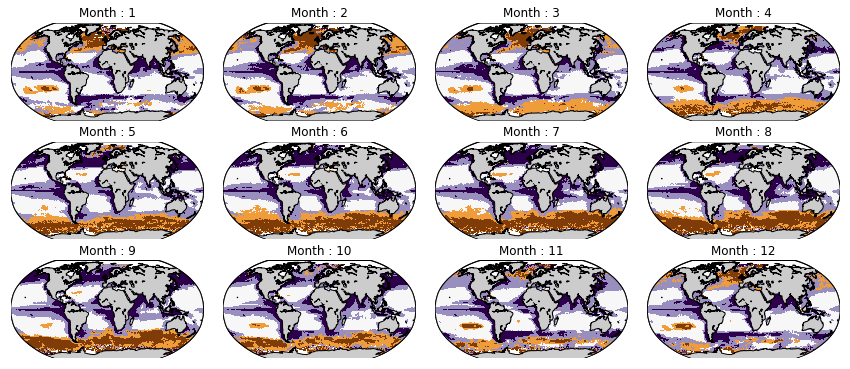

In [61]:
fig, axes = plt.subplots(3, 4, figsize=(12, 5))
plt.subplots_adjust(0.02, 0.02, 0.98, 0.98, wspace=0.1, hspace=0.1)
axef = axes.ravel()
for m in range(12):
    bmap.drawcoastlines(ax=axef[m])
    bmap.fillcontinents(ax=axef[m])
    bmap.pcolormesh(x, y, np.ma.array(cluster_grid[m], mask=cluster_grid[m] < 0), 
               vmin=-0.5, vmax=4.5, cmap=plt.get_cmap("PuOr", 5),
                   ax=axef[m])
    axef[m].set_title("Month : {0:d}".format(m+1))
    bmap.drawmapboundary(ax=axef[m])

plt.savefig("sat_cluster_month.png", dpi=300, bbox_inches="tight")

In [373]:
ax = axef[m]
ax.set_

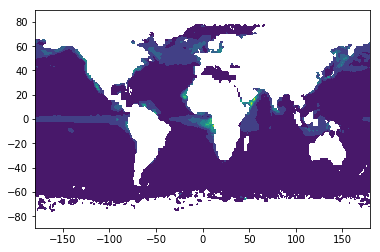

In [225]:
plt.contourf(FecEZ_da.lon, FecEZ_da.lat, FecEZ_da.groupby("month").mean(axis=0)[6])

In [210]:
combined_df["cluster_id"].values.reshape(12, 180, 360)[0].max()

4

In [198]:
AlgEZ_da.groupby("month").mean(axis=0).to_dataframe().dropna()

algez
month lat   lon              
1     -77.5 -179.5   5.875122
            -178.5   5.561867
            -177.5   6.465196
            -176.5   6.460538
            -175.5   6.706752
            -174.5   5.684390
            -173.5   4.606354
            -172.5   3.825506
            -171.5   2.859280
            -170.5   3.241139
            -168.5   3.879639
            -167.5   4.735935
            -166.5   6.020321
            -163.5   6.342936
            -162.5   6.532860
            -161.5   7.629853
            -160.5   8.586822
            -159.5   7.972595
            -158.5   7.704387
             172.5  15.280636
             173.5  16.339946
             175.5  15.446940
             178.5   7.677405
             179.5   6.209502
      -76.5 -179.5   5.873653
            -178.5   6.692301
            -177.5   6.426127
            -176.5   5.814183
            -175.5   5.652414
            -174.5   5.067283
...                       ...
12     77.5 -0.5    39.588438
             1.5    68.441678
             2.5    30.532239
             12.5    8.343027
             13.5    6.567423
             18.5   40.467214
             24.5   10.854255
             25.5   30.348184
             27.5   21.507830
             28.5   22.191209
             29.5   59.787108
             30.5    0.040328
             31.5    0.309869
             32.5   46.034276
             33.5   60.151810
             35.5   45.333595
             36.5   39.739112
             37.5   37.493233
             38.5   46.935968
             39.5   21.482551
             44.5   27.482573
             45.5   23.061759
             46.5   20.262675
             55.5    5.508224
             56.5   36.363250
             59.5   21.502741
             60.5    0.236209
             65.5    0.706554
             66.5    4.203734
             67.5   13.699161

[428431 rows x 1 columns]

In [196]:
FecEZ_da.groupby("month").mean(axis=0).to_dataframe().dropna()

fecez
month lat   lon               
1     -77.5 -179.5    0.000000
            -178.5    0.000000
            -177.5    0.000000
            -176.5    0.000000
            -175.5    0.000000
            -174.5    0.000000
            -173.5    0.000000
            -172.5    0.000000
            -171.5    0.000000
            -170.5    0.000000
            -168.5    0.000000
            -167.5    0.000000
            -166.5    0.000000
            -163.5    0.656790
            -162.5    2.044952
            -161.5    1.096154
            -160.5    0.220124
            -159.5    0.074062
            -158.5    0.056013
             172.5    4.475268
             173.5   10.189484
             175.5   13.122193
             178.5    0.501340
             179.5    0.000000
      -76.5 -179.5    1.428554
            -178.5    0.159334
            -177.5    0.000000
            -176.5    0.000000
            -175.5    0.000000
            -174.5    0.000000
...                        ...
12     76.5  34.5     0.052330
             35.5    15.131921
             36.5     8.975704
             37.5     4.472055
             38.5    29.058853
             39.5    36.926059
             48.5     0.000000
             49.5     0.000000
             53.5     0.000000
             54.5     0.000000
             55.5    39.061436
             56.5    66.509711
             57.5    89.325202
             58.5     9.817810
             61.5    33.683274
             62.5    11.153185
             63.5     0.000000
             64.5     0.000000
             65.5     0.000000
             69.5    45.953255
       77.5 -7.5    101.165675
            -5.5    104.494488
            -4.5     44.215767
            -2.5    208.027291
             27.5     0.000000
             35.5   139.471482
             56.5    73.064457
             59.5    56.006328
             65.5     0.000000
             67.5     0.000000

[425228 rows x 1 columns]

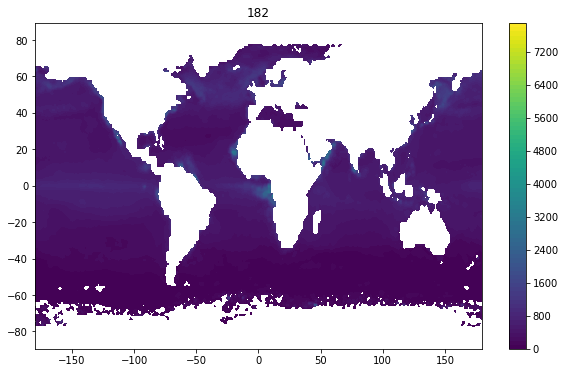

<function __main__.plot_day>

In [126]:
def plot_day(day):
    plt.figure(figsize=(10, 6))
    plt.contourf(data["lon"], data["lat"], np.ma.array(data["data"][day], mask=data["data"][day]==1e20), np.arange(0, 8000, 100))
    plt.colorbar()
    plt.title(day)
    plt.show()
interact(plot_day, day=(0, 365))

In [78]:
data["data"][data["data"] < 1e20].max()

8017.4476491449004

In [81]:
np.where(data["data"] < 1e20)

(array([  0,   0,   0, ..., 364, 364, 364]),
 array([ 12,  12,  12, ..., 167, 167, 167]),
 array([  0,   1,   2, ..., 245, 246, 247]))